In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds['analysed_sst'] = ds.analysed_sst - 273.15

In [3]:
#Get the selected data as a reference 2002-2012 data
test = ds.sel(time=slice('2002-06-01', '2012-12-31'))

In [4]:
#calculating the mean and sd
test_mean = test.analysed_sst.groupby('time.month').mean()
test_sd = test.analysed_sst.groupby('time.month').std()

In [5]:
#segmenting the dataset based on year
ds_2014 = ds.sel(time=slice('2014-01-01', '2014-12-31'))
ds_2015 = ds.sel(time=slice('2015-01-01', '2015-12-31'))
ds_2016 = ds.sel(time=slice('2016-01-01', '2016-12-31'))

In [6]:
#calculate the means for each month for each selected year
ds_2014m = ds_2014.analysed_sst.groupby('time.month').mean()
ds_2015m = ds_2015.analysed_sst.groupby('time.month').mean()
ds_2016m = ds_2016.analysed_sst.groupby('time.month').mean()

In [7]:
#calcualte the difference between monthly average and mean for each year 2014-2016
diff_2014 = ds_2014m - test_mean
diff_2015 = ds_2015m - test_mean
diff_2016 = ds_2016m - test_mean

In [8]:
#calculate the standard deviation
sd_2014 = diff_2014 / test_sd
sd_2015 = diff_2015 / test_sd
sd_2016 = diff_2016 / test_sd

In [9]:
#add a dimension 'year' to the data arrays
sd_2014 = sd_2014.assign_coords(year="year").expand_dims(dim=dict(year= [2014]))
sd_2015 = sd_2015.assign_coords(year="year").expand_dims(dim=dict(year= [2015]))
sd_2016 = sd_2016.assign_coords(year="year").expand_dims(dim=dict(year= [2016]))

In [10]:
combined_anomalies = xr.merge([sd_2014, sd_2015, sd_2016])
anomaly = combined_anomalies.analysed_sst

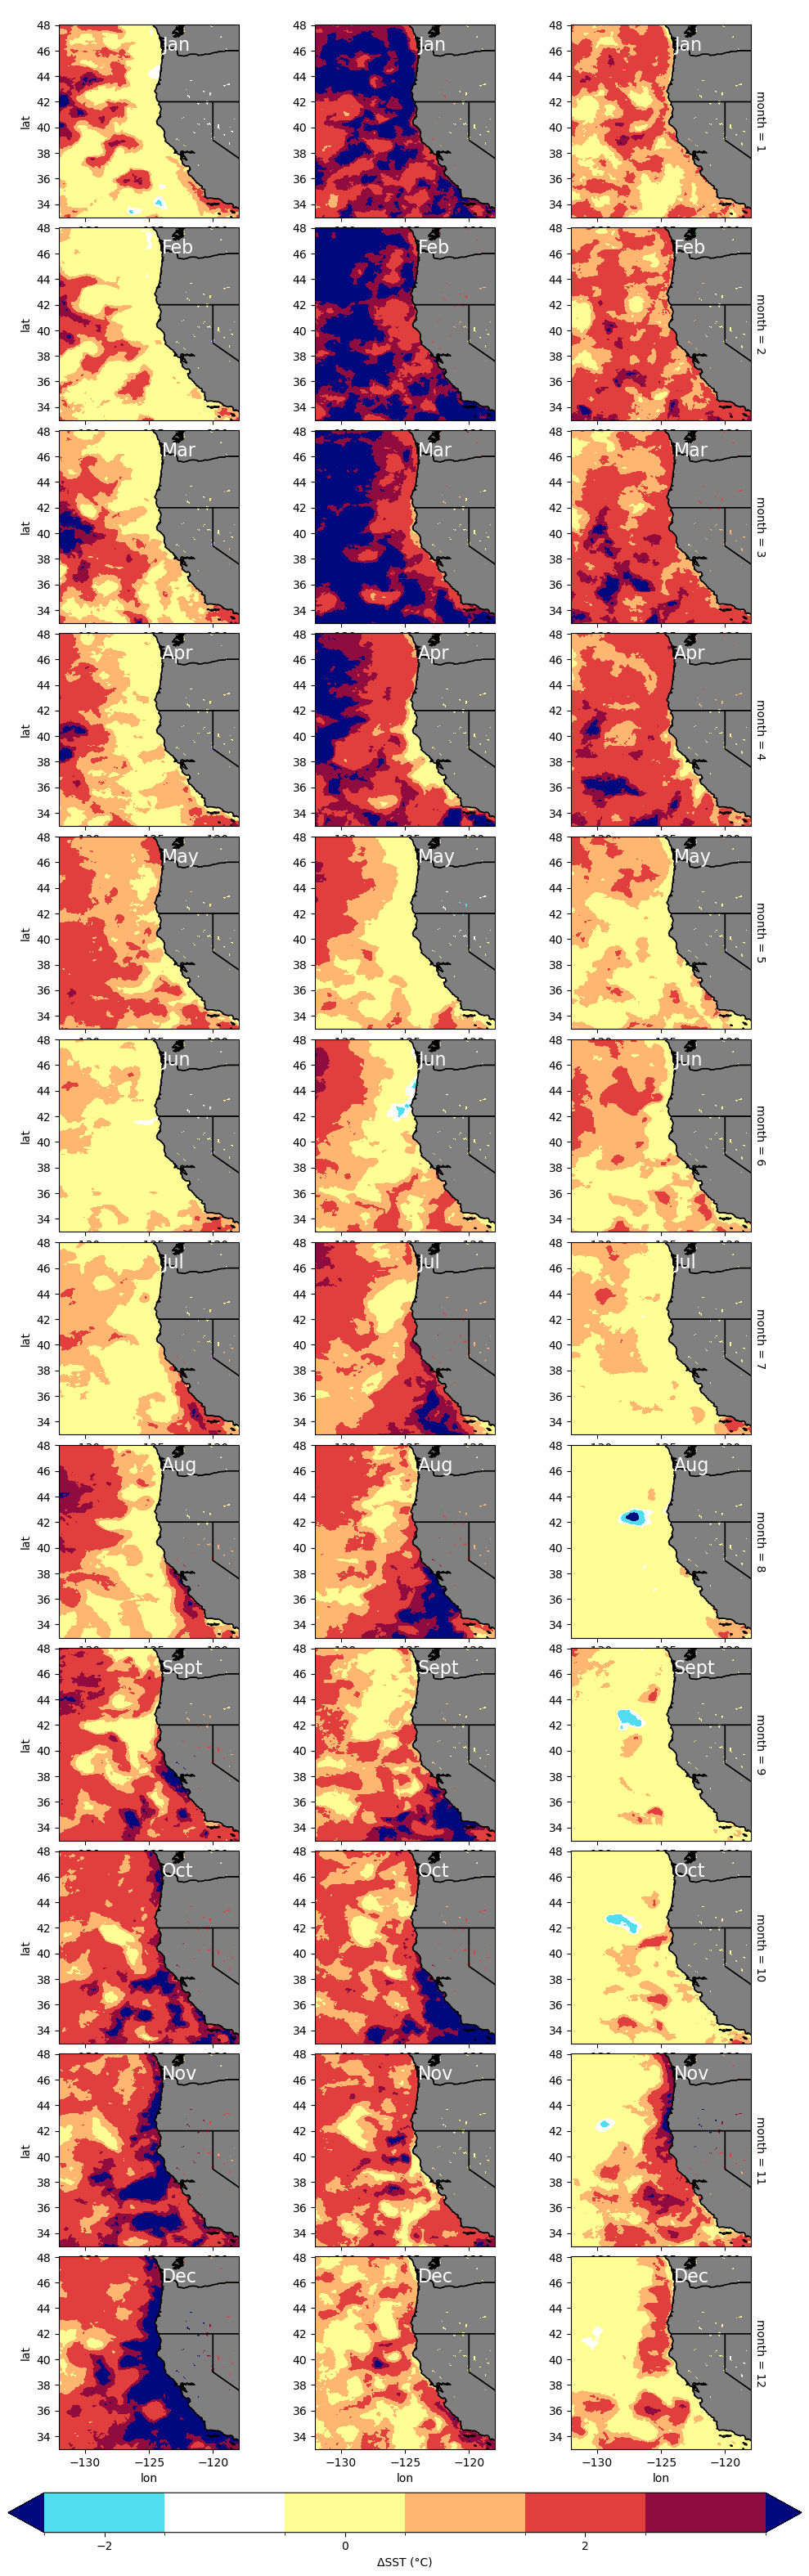

In [11]:
#plot
levels = [-2.5, -1.5, -1, 1, 1.5,2.5,3]
colors = ["#00087E", "#50DDF0", "#FFFFFF", "#FFFE95", "#FFB671", "#E13E3E" , "#900C3F"]
z = anomaly.plot(col='year', row = "month", x = 'lon', y = 'lat', col_wrap=3, transform=ccrs.PlateCarree(),
                            #vmin=-3, vmax=3,
                            levels = levels, colors = colors,
                            subplot_kws={'projection': ccrs.PlateCarree()},
                            cbar_kwargs={'orientation': 'horizontal', 'label' : 'ΔSST (°C)', "ticks":[-2,0,2], 'pad':0.015});

#z.fig.suptitle("2016", y = 0.995, x = 0.5)
#titles = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
titles = np.repeat(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"],repeats=3)
for ax, title in zip(z.axes.flatten(), titles):
    ax.annotate(title, xy = (-124, 46), fontsize = 16, color = "white")
    ax.set_title(" ", fontsize=12)

for ax in z.axes.flat:
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines("10m", color="k")
    ax.add_feature(cfeature.LAND, color="grey")
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    ax.get_yaxis().set_visible(True)
    #ax.get_xaxis().set_visible(True)

In [15]:
#TO DO:
#change x and y axis
#Is the plot wrong??- look at numbers??
#custom colorplot, not a gradient- more discrete
#borders around colors

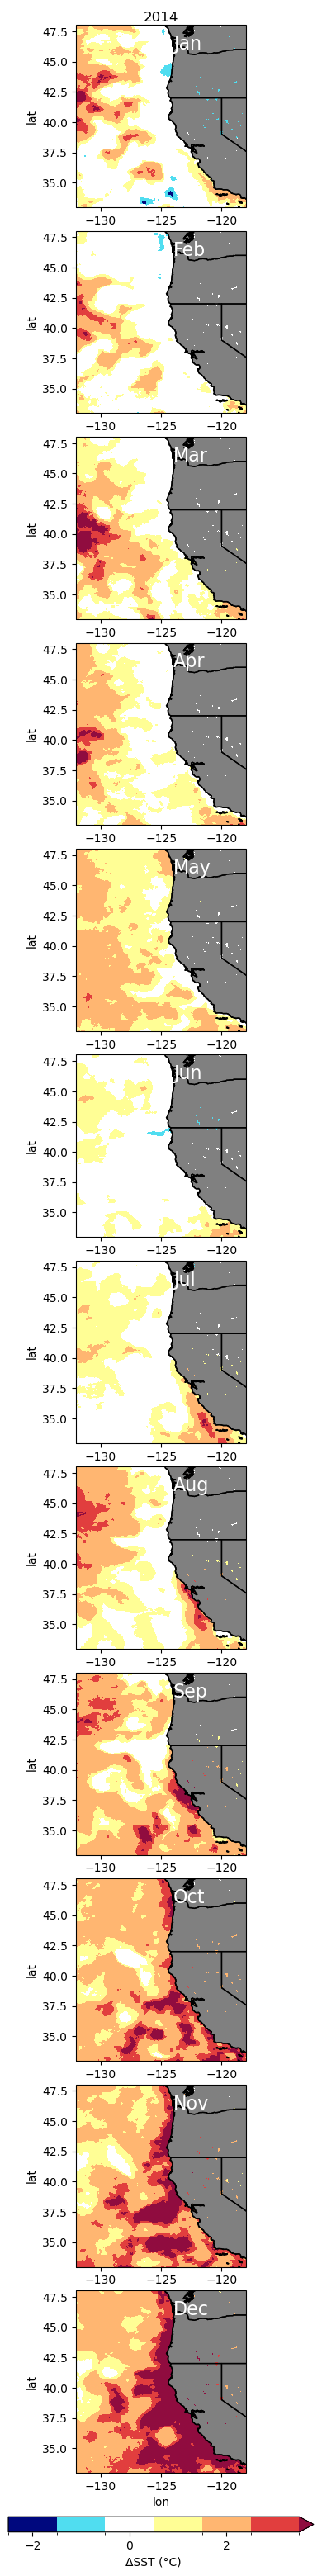

In [12]:
#plot for a single year- 2014 with (almost) all attributes
levels = [-2.5, -1.5, -1, 1, 1.5,2.5,3]
colors = ["#00087E", "#50DDF0", "#FFFFFF", "#FFFE95", "#FFB671", "#E13E3E" , "#900C3F"]

p = sd_2014.plot(col='month', x = 'lon', y = 'lat', col_wrap=1, transform=ccrs.PlateCarree(),
                            levels = levels, colors = colors,
                            #cmap="seismic",
                            subplot_kws={'projection': ccrs.PlateCarree()},
                            cbar_kwargs={'orientation': 'horizontal', 'label' : 'ΔSST (°C)', "ticks":[-2,0,2],'pad':0.015});
#'spacing':'proportional', "ticks":levels
p.fig.suptitle("2014", y = 0.995, x = 0.5)
titles = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for ax, title in zip(p.axes.flatten(), titles):
    ax.annotate(title, xy = (-124, 46), fontsize = 16, color = "white")
    ax.set_title(" ", fontsize=12)

for ax in p.axes.flat:
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines("10m", color="k")
    ax.add_feature(cfeature.LAND, color="grey")
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)